[Getting Started with Cloud KMS](https://www.cloudskillsboost.google/focuses/1713?parent=catalog)

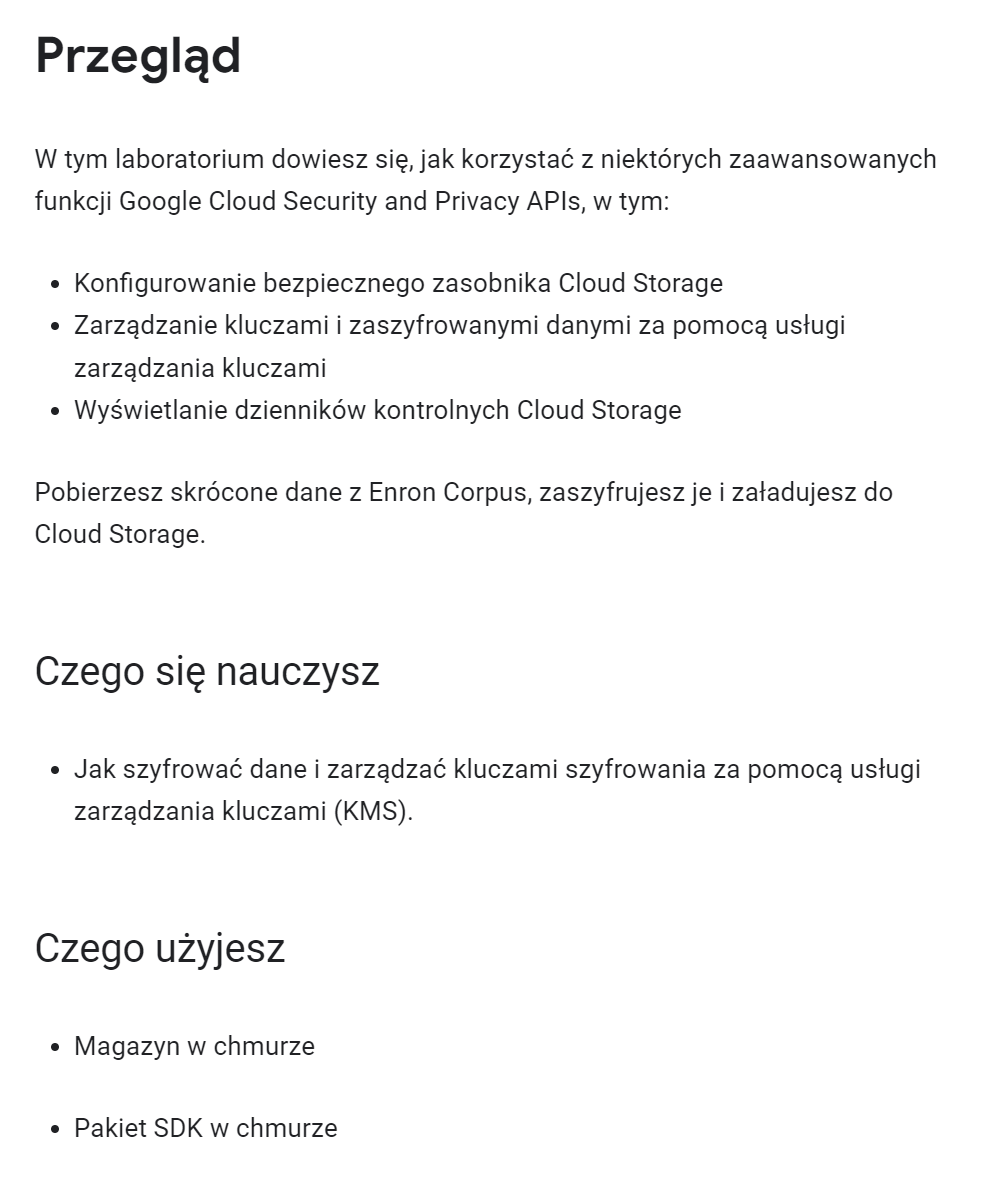

In [ ]:
# https://en.wikipedia.org/wiki/Enron_Corpus

KMS (Key Management Service) to usługa oferowana przez Google Cloud Platform (GCP), która umożliwia zarządzanie kluczami szyfrowania w chmurze. KMS zapewnia bezpieczne przechowywanie, generowanie i zarządzanie kluczami kryptograficznymi wykorzystywanymi do szyfrowania i deszyfrowania danych w usługach GCP oraz w aplikacjach zewnętrznych.

Główne funkcje i zastosowania KMS w kontekście GCP to:

1. Zarządzanie kluczami: KMS umożliwia tworzenie, importowanie i zarządzanie kluczami szyfrowania. Klucze są przechowywane w bezpieczny sposób i mogą być wykorzystywane do szyfrowania danych w różnych usługach GCP.

2. Szyfrowanie danych: KMS dostarcza API, które umożliwia szyfrowanie i deszyfrowanie danych przy użyciu zarządzanych kluczy. Można szyfrować dane na potrzeby przechowywania, przesyłania lub przetwarzania, zapewniając tym samym ich poufność.

3. Zarządzanie uprawnieniami: KMS umożliwia definiowanie precyzyjnych uprawnień dostępu do kluczy. Można określić, które usługi lub użytkownicy mają dostęp do konkretnych kluczy i jakie operacje mogą wykonywać na tych kluczach.

4. Audytowanie działań: KMS automatycznie rejestruje wszystkie operacje wykonywane na kluczach, co umożliwia audytowanie i monitorowanie ich użycia. Można sprawdzić, kto, kiedy i jak korzystał z kluczy szyfrowania.

5. Integracja z innymi usługami: KMS ściśle integruje się z innymi usługami GCP, takimi jak Cloud Storage, BigQuery, Cloud SQL itp. Można wykorzystywać zarządzane klucze KMS do szyfrowania danych w tych usługach.

Dzięki KMS, użytkownicy GCP mogą łatwo zarządzać kluczami szyfrowania i zapewnić bezpieczeństwo swoich danych przechowywanych w chmurze. KMS dostarcza zaawansowane funkcje kryptograficzne oraz zapewnia audyt i kontrolę dostępu do kluczy, co przyczynia się do utrzymania wysokiego poziomu bezpieczeństwa danych w GCP.

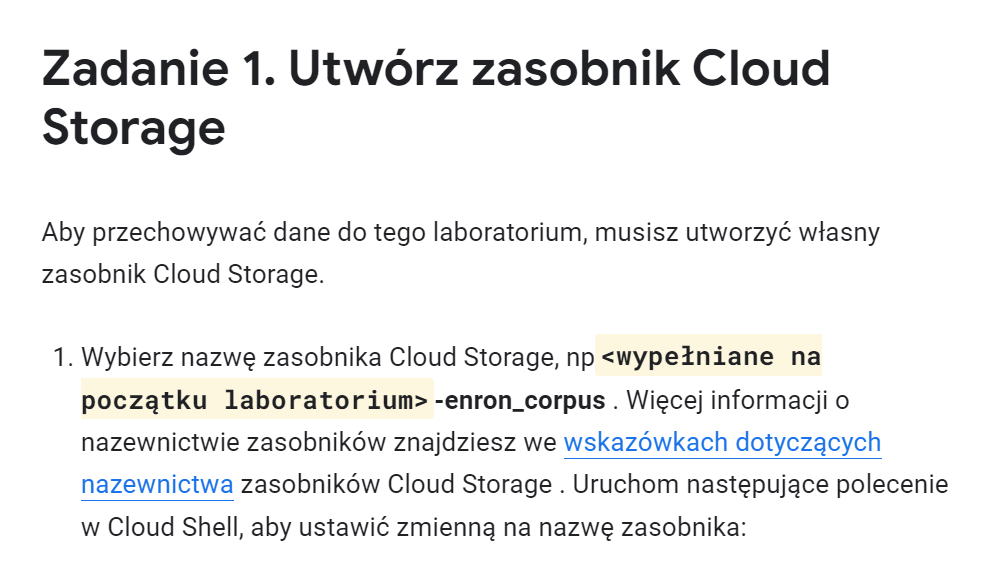

In [ ]:
BUCKET_NAME="exam-584848-enron_corpus"

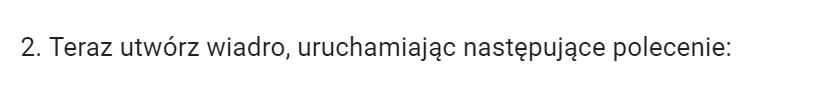

In [ ]:
gsutil mb gs://${BUCKET_NAME}

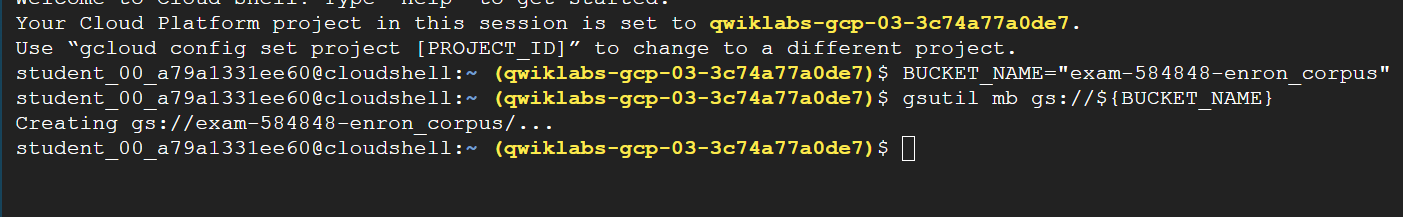

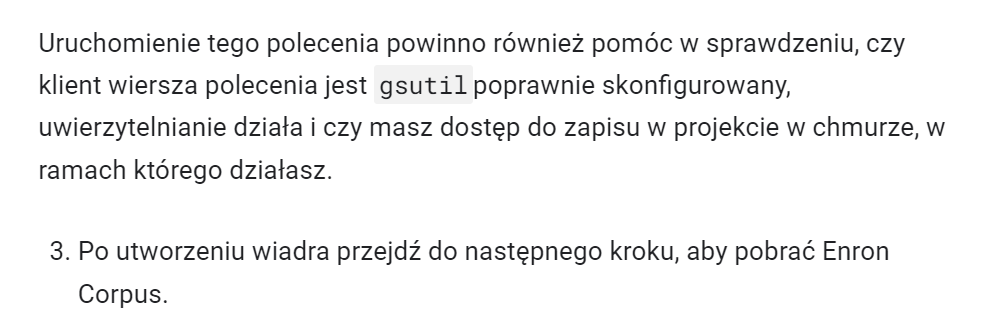

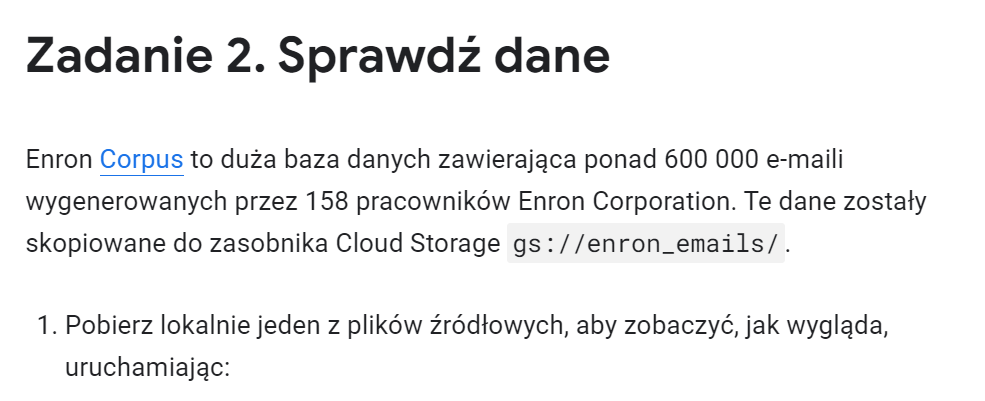

In [ ]:
gsutil cp gs://enron_emails/allen-p/inbox/1. .

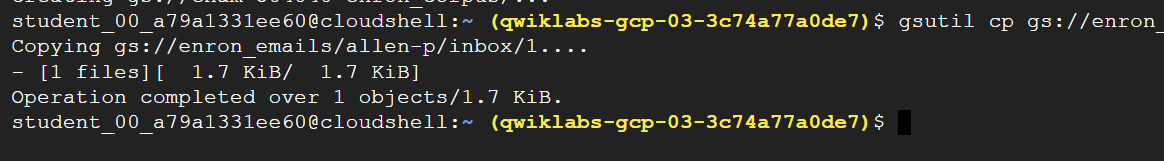

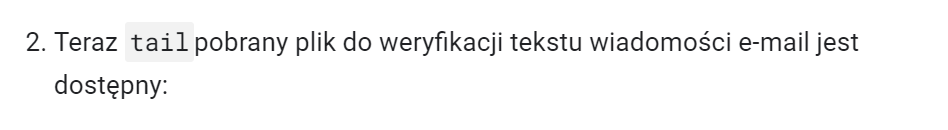

In [ ]:
tail 1.

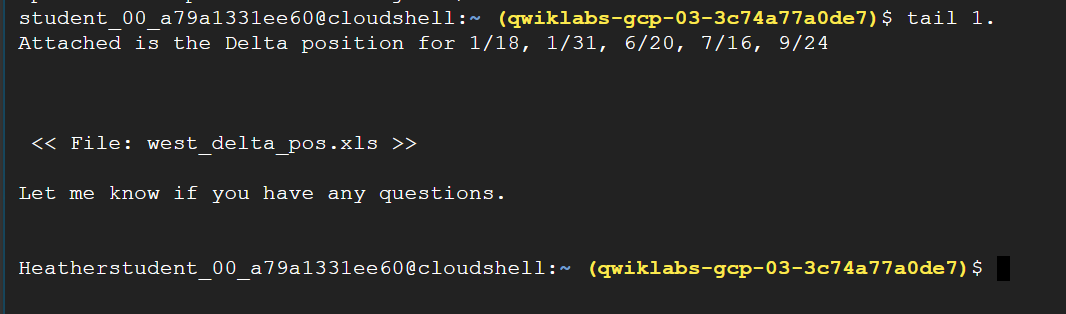

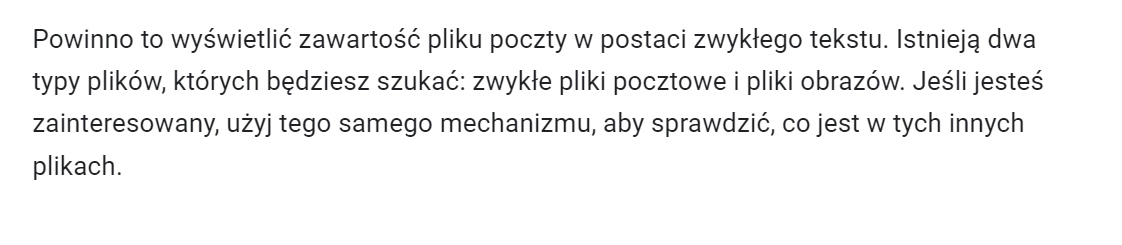

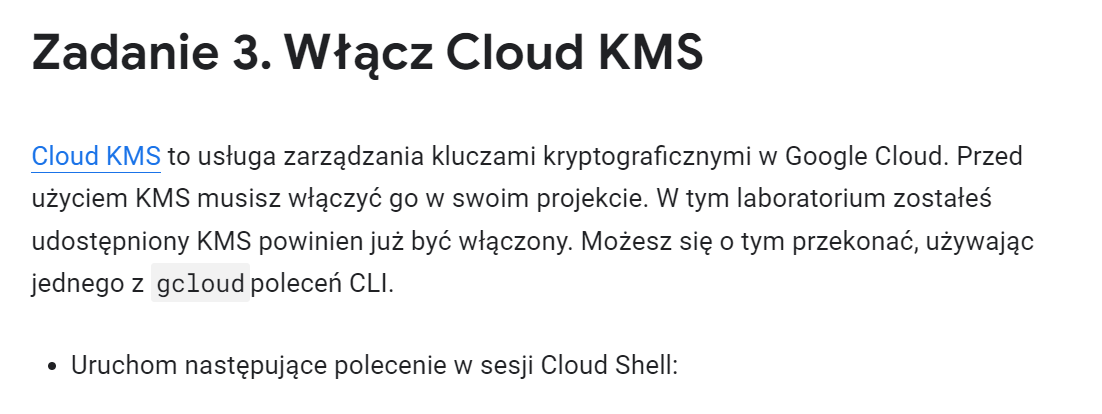

In [ ]:
# https://cloud.google.com/security-key-management

In [ ]:
gcloud services enable cloudkms.googleapis.com

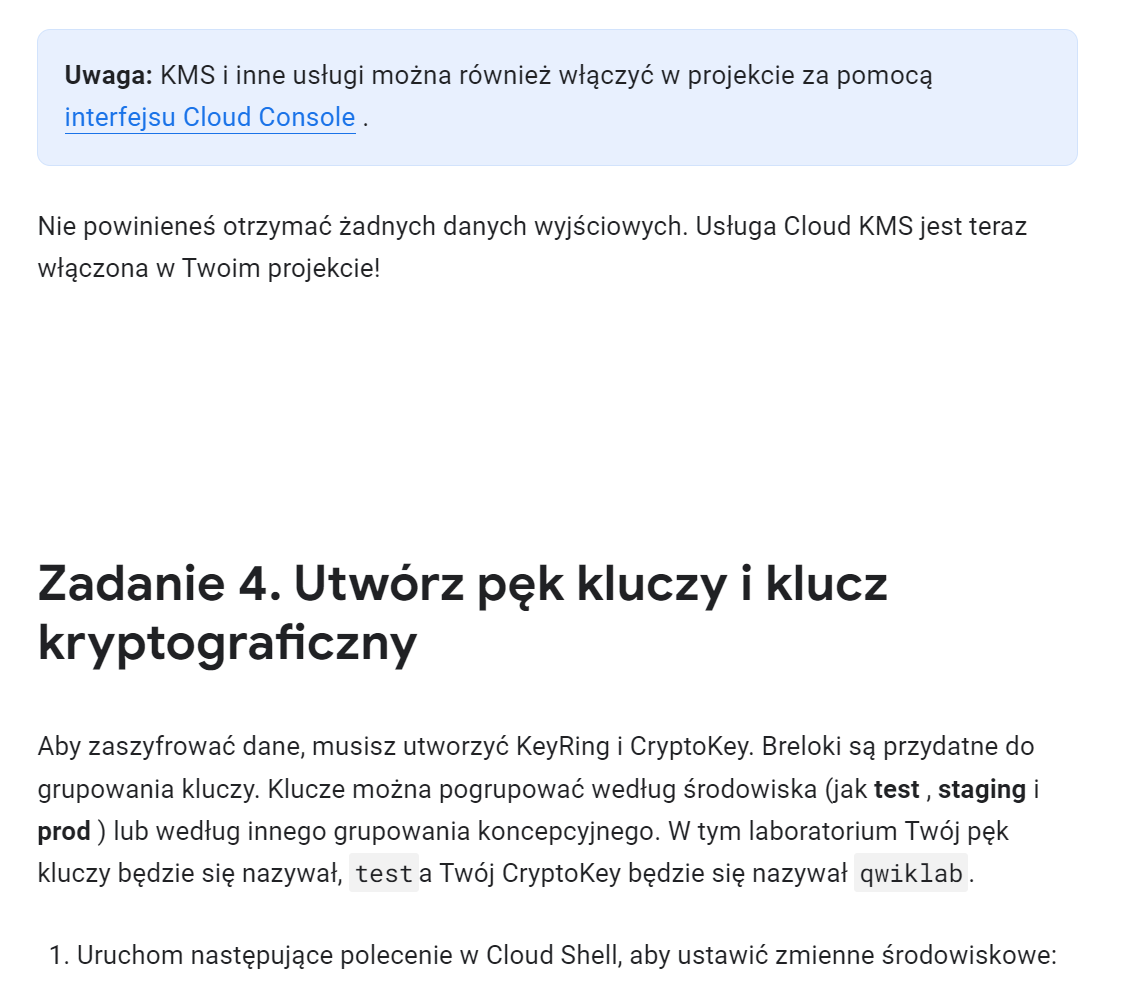

In [ ]:
KEYRING_NAME=test CRYPTOKEY_NAME=qwiklab

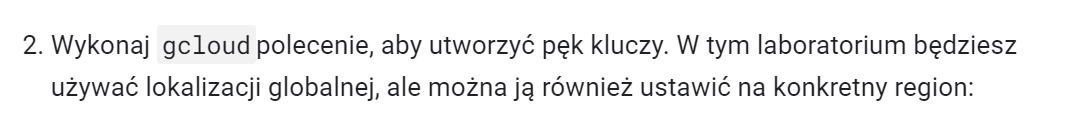

In [ ]:
gcloud kms keyrings create $KEYRING_NAME --location global

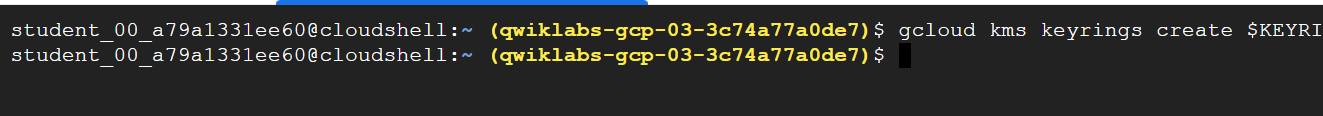

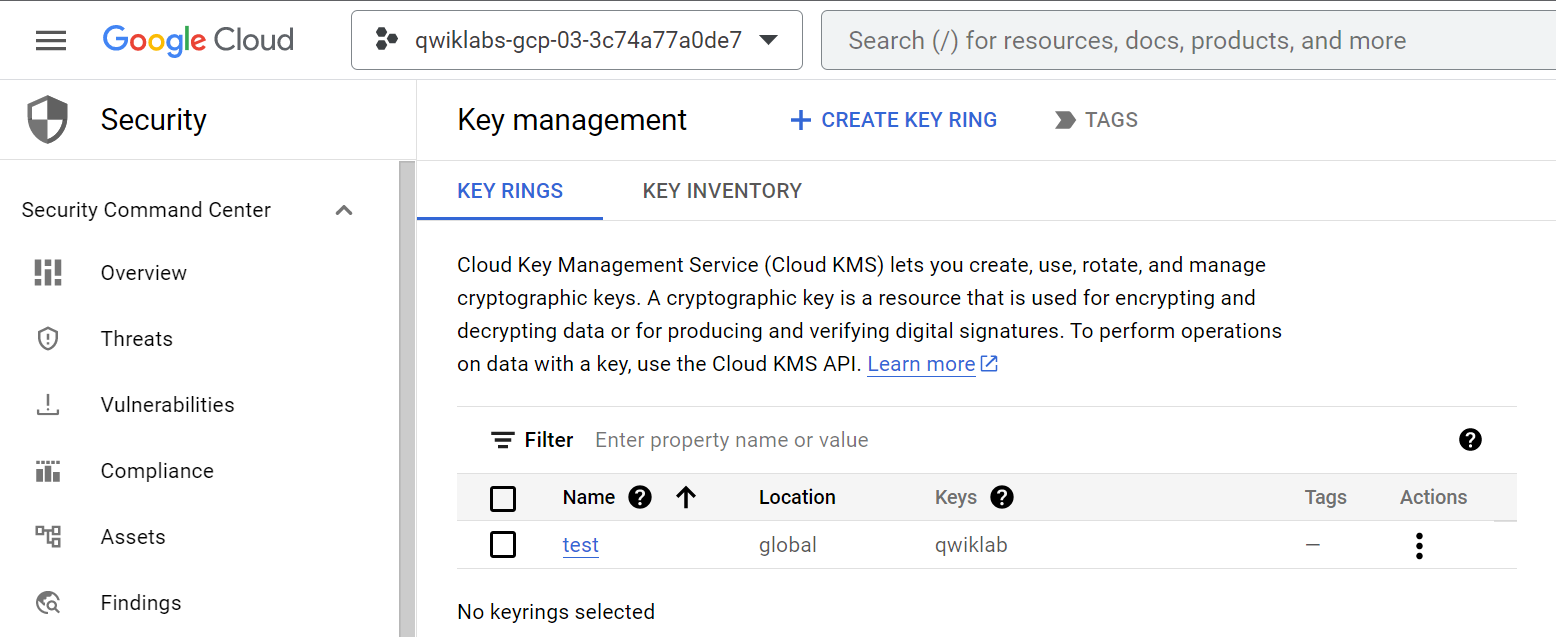

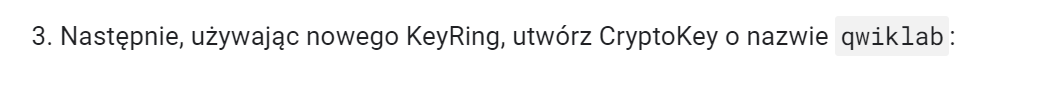

In [ ]:
gcloud kms keys create $CRYPTOKEY_NAME --location global \
      --keyring $KEYRING_NAME \
      --purpose encryption

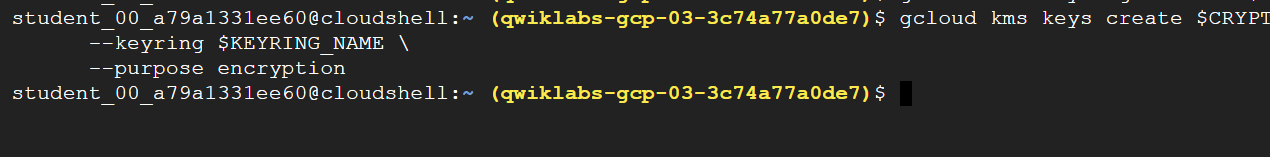

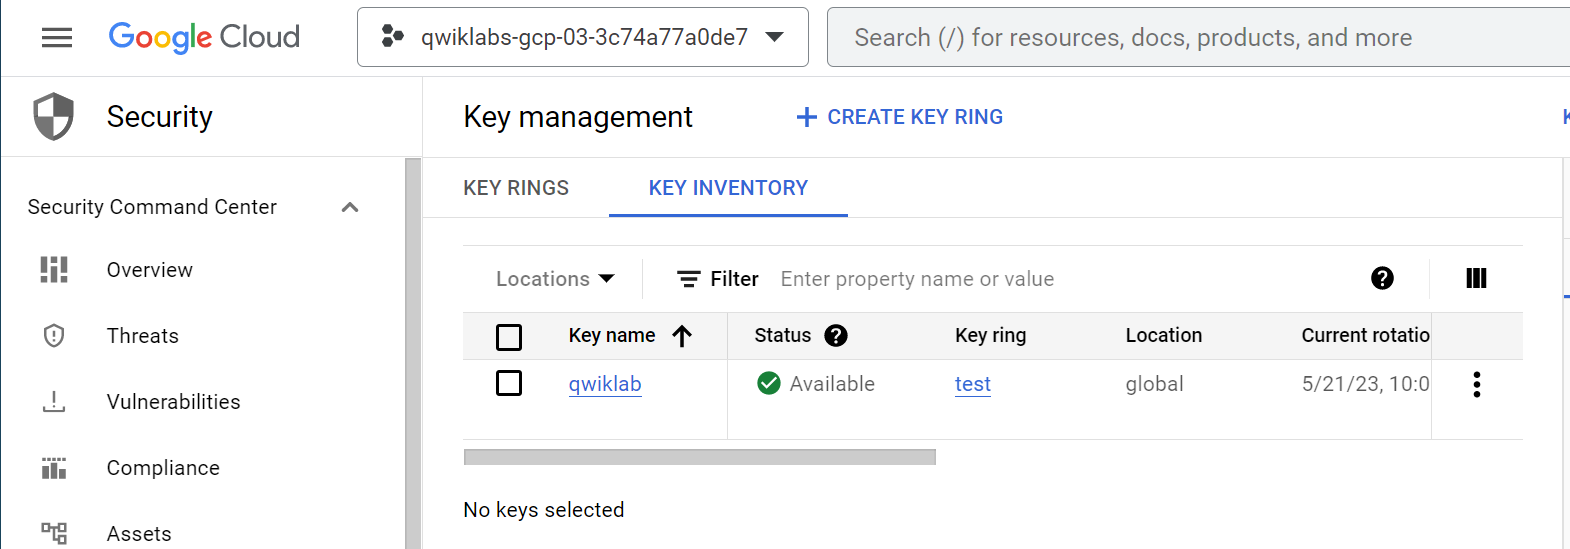

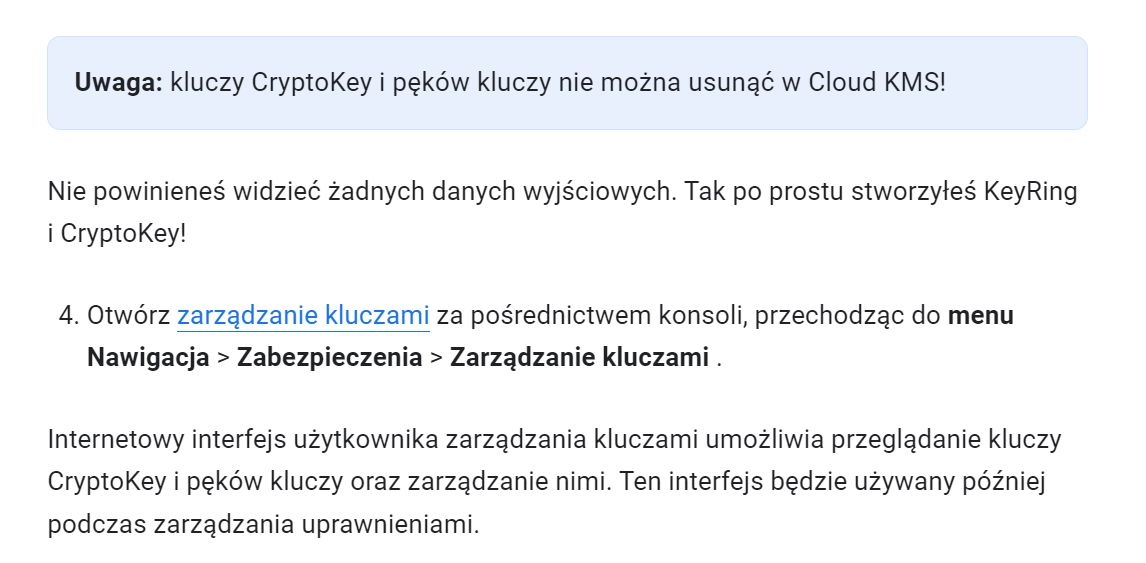

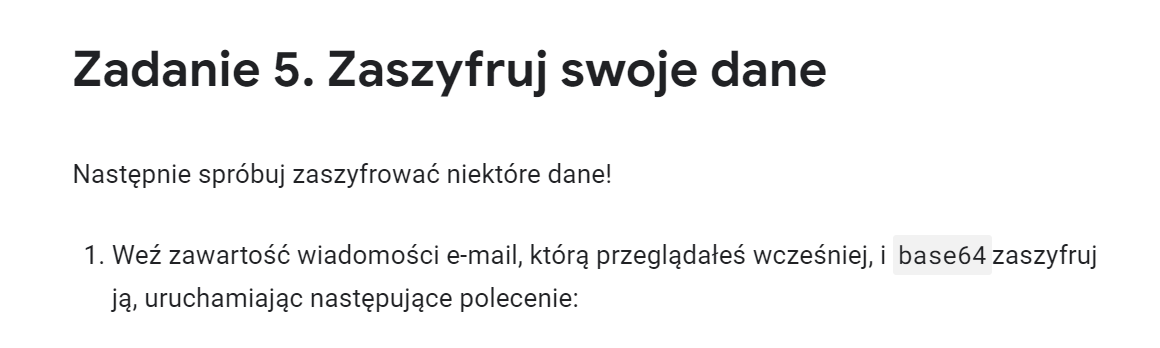

In [ ]:
PLAINTEXT=$(cat 1. | base64 -w0)

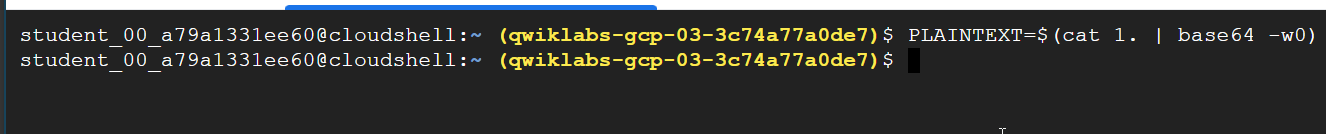

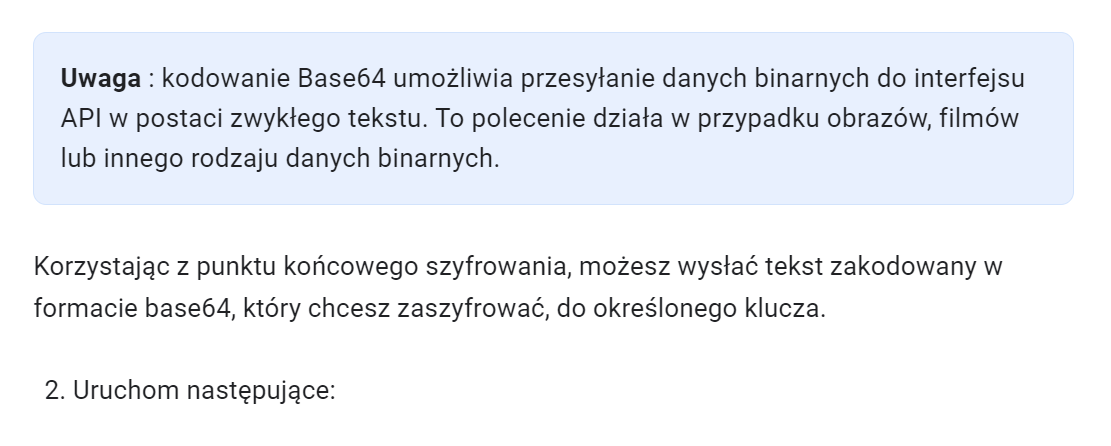

In [ ]:
curl -v "https://cloudkms.googleapis.com/v1/projects/$DEVSHELL_PROJECT_ID/locations/global/keyRings/$KEYRING_NAME/cryptoKeys/$CRYPTOKEY_NAME:encrypt" \
  -d "{\"plaintext\":\"$PLAINTEXT\"}" \
  -H "Authorization:Bearer $(gcloud auth application-default print-access-token)"\
  -H "Content-Type: application/json"

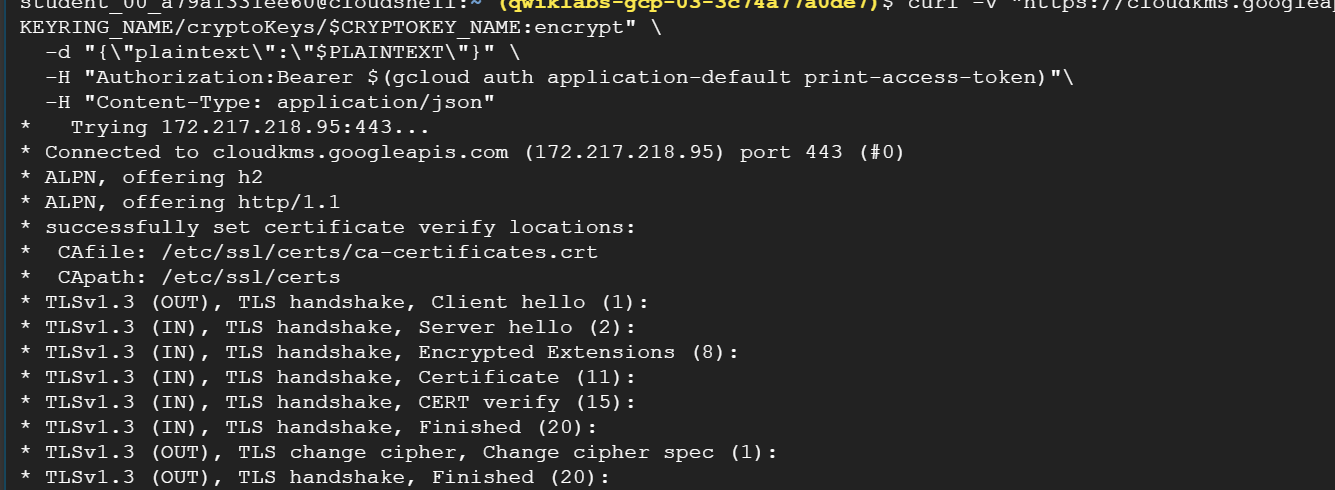

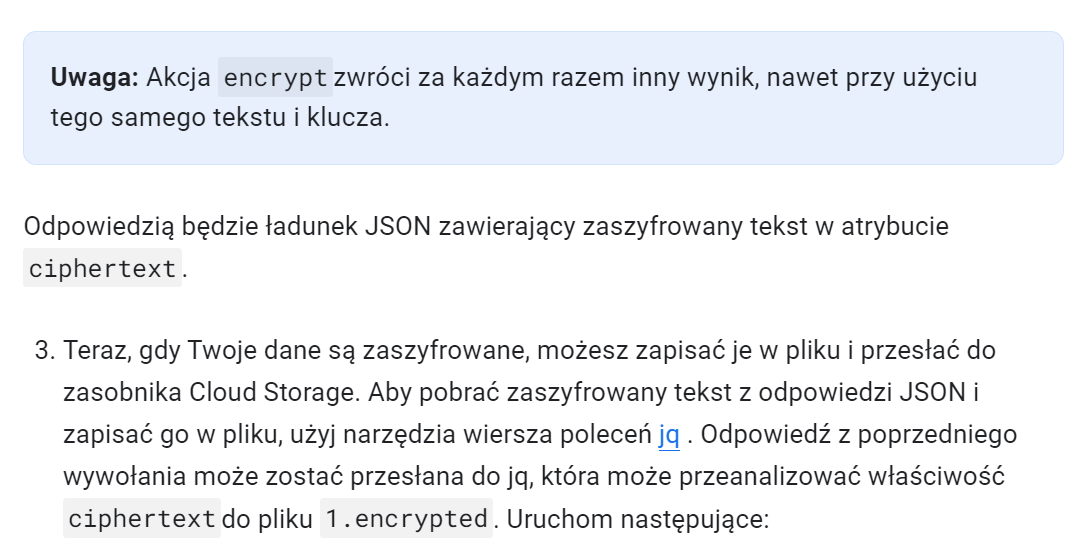

In [ ]:
# https://stedolan.github.io/jq/

In [ ]:
curl -v "https://cloudkms.googleapis.com/v1/projects/$DEVSHELL_PROJECT_ID/locations/global/keyRings/$KEYRING_NAME/cryptoKeys/$CRYPTOKEY_NAME:encrypt" \
  -d "{\"plaintext\":\"$PLAINTEXT\"}" \
  -H "Authorization:Bearer $(gcloud auth application-default print-access-token)"\
  -H "Content-Type:application/json" \
| jq .ciphertext -r > 1.encrypted

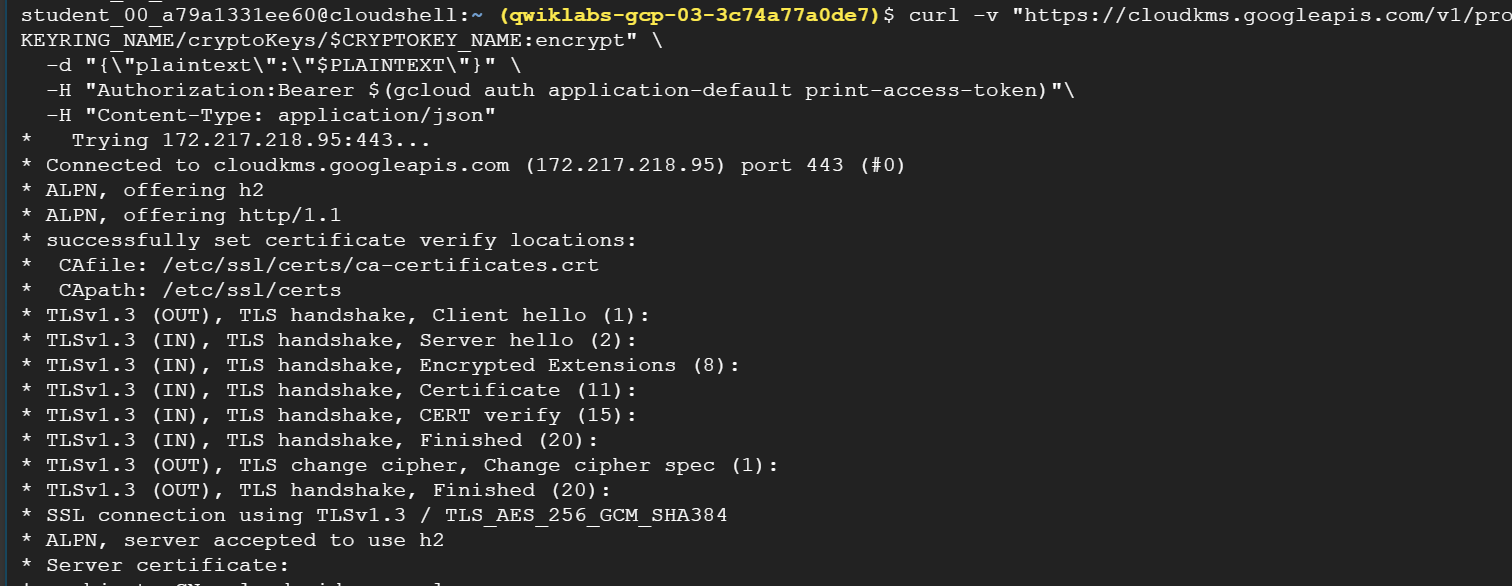

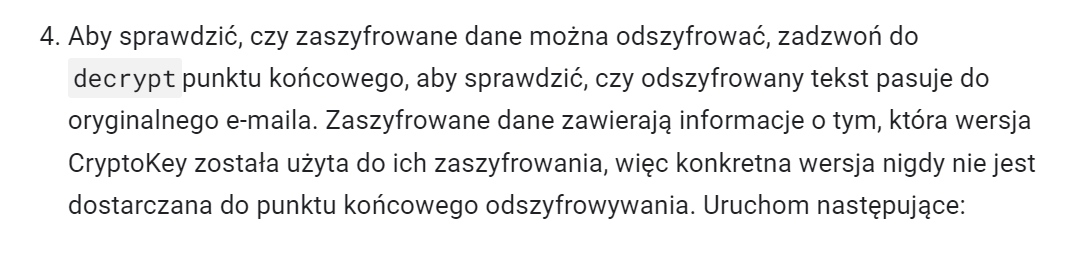

In [ ]:
curl -v "https://cloudkms.googleapis.com/v1/projects/$DEVSHELL_PROJECT_ID/locations/global/keyRings/$KEYRING_NAME/cryptoKeys/$CRYPTOKEY_NAME:decrypt" \
  -d "{\"ciphertext\":\"$(cat 1.encrypted)\"}" \
  -H "Authorization:Bearer $(gcloud auth application-default print-access-token)"\
  -H "Content-Type:application/json" \
| jq .plaintext -r | base64 -d

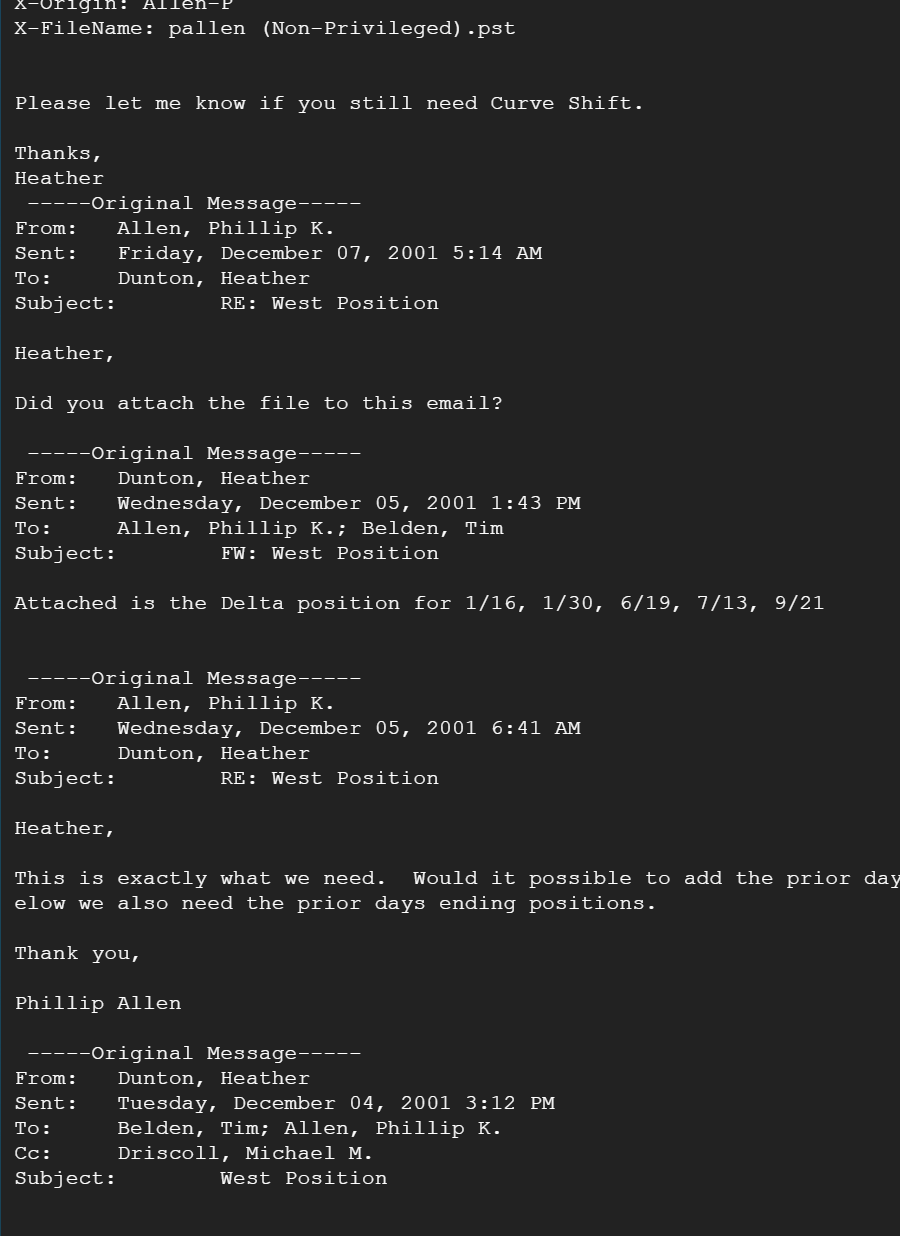

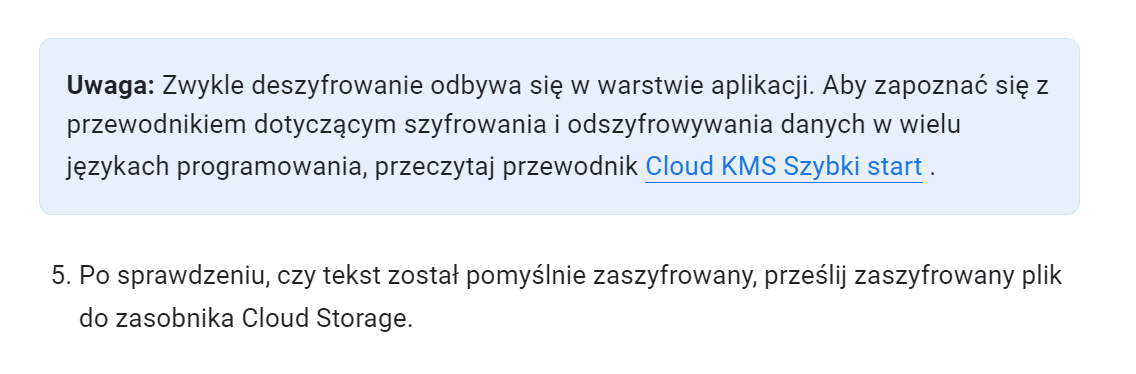

In [ ]:
# https://cloud.google.com/kms/docs/create-encryption-keys

In [ ]:
gsutil cp 1.encrypted gs://${BUCKET_NAME}

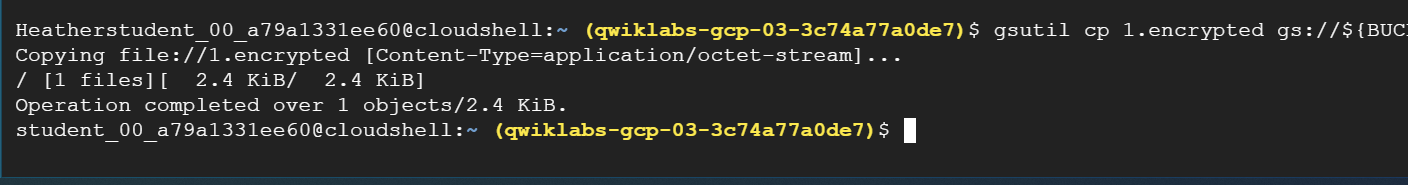

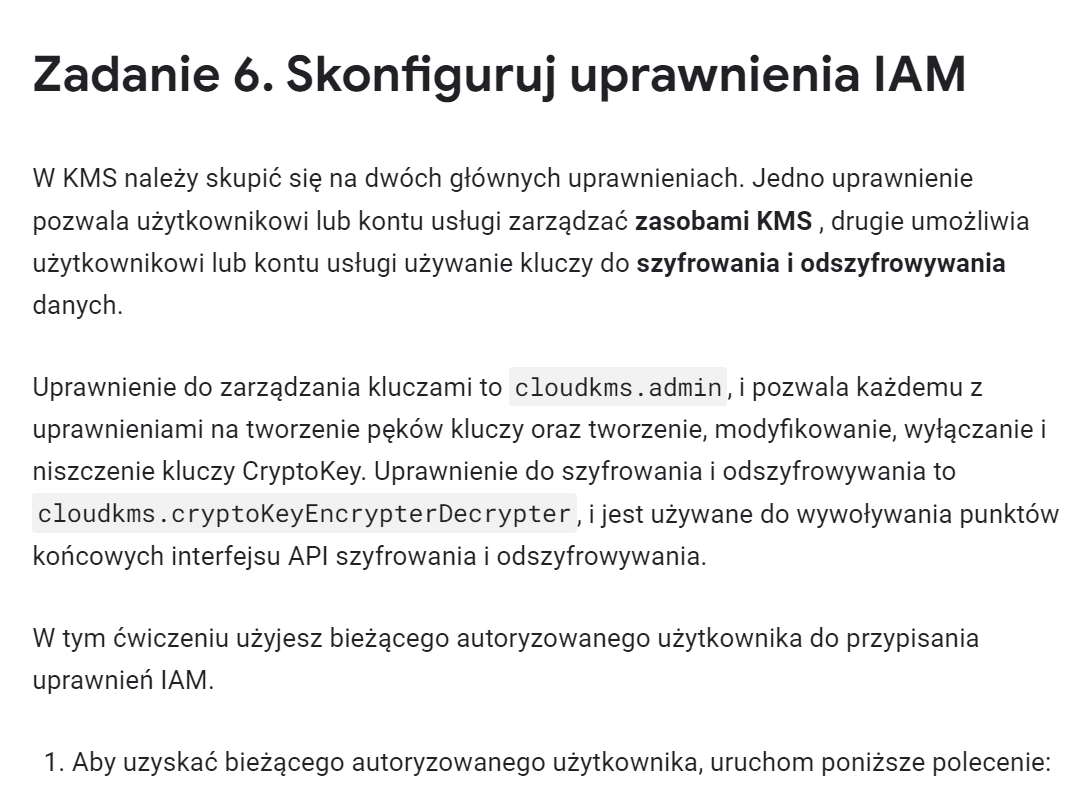

In [ ]:
USER_EMAIL=$(gcloud auth list --limit=1 2>/dev/null | grep '@' | awk '{print $2}')

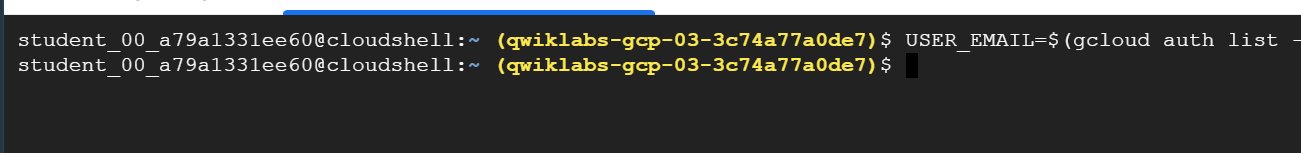

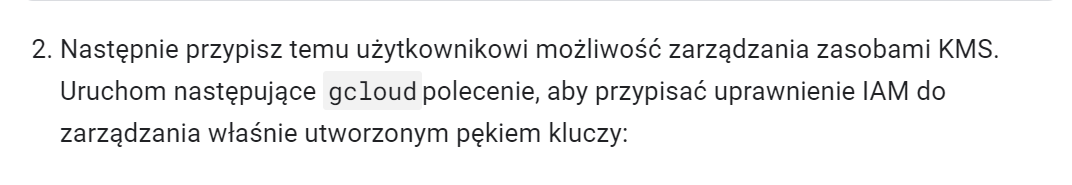

In [ ]:
gcloud kms keyrings add-iam-policy-binding $KEYRING_NAME \
    --location global \
    --member user:$USER_EMAIL \
    --role roles/cloudkms.admin

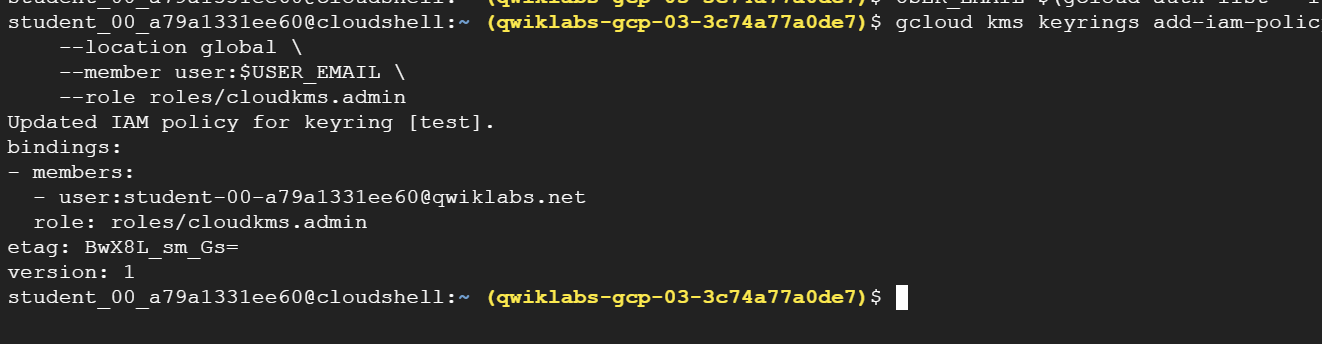

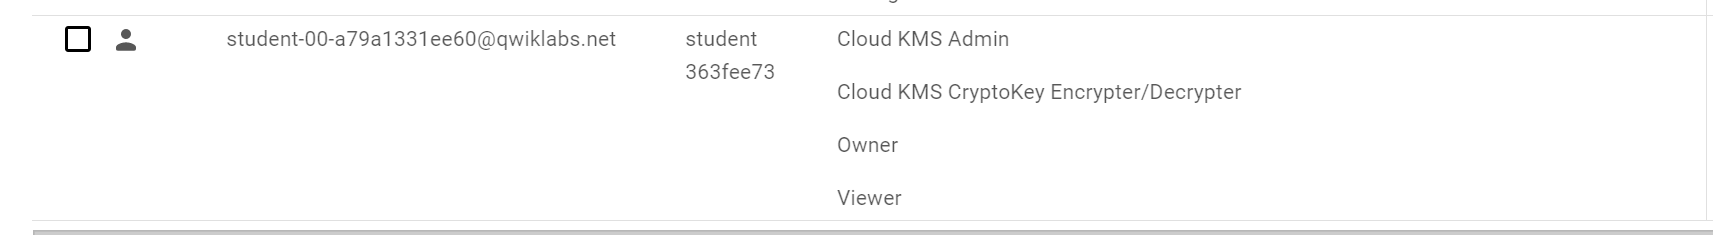

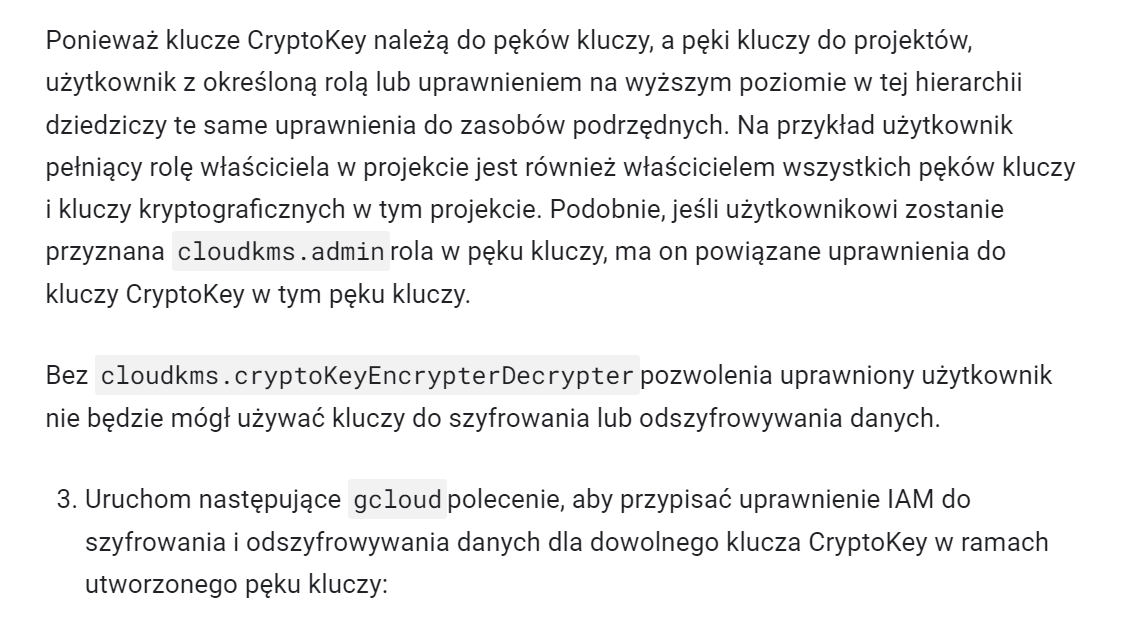

In [ ]:
gcloud kms keyrings add-iam-policy-binding $KEYRING_NAME \
    --location global \
    --member user:$USER_EMAIL \
    --role roles/cloudkms.cryptoKeyEncrypterDecrypter

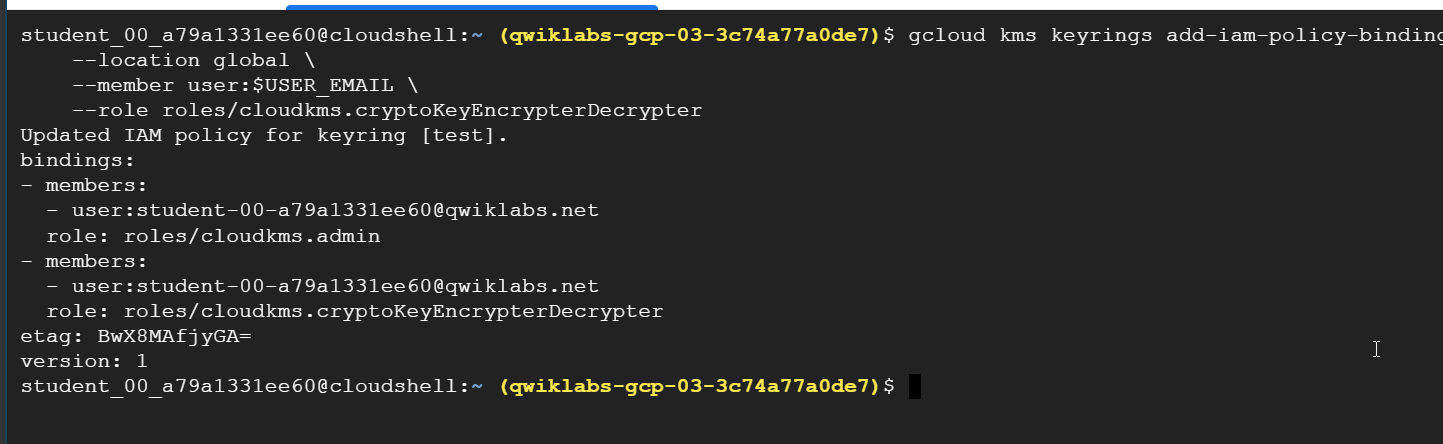

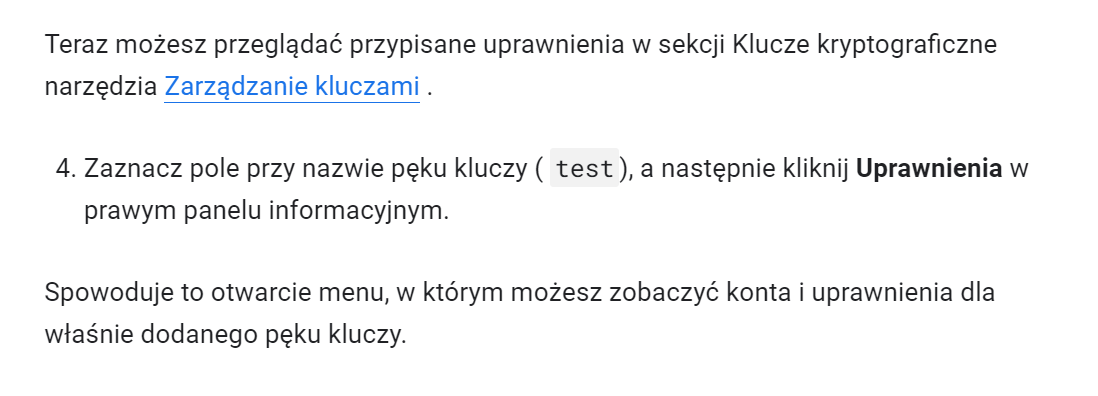

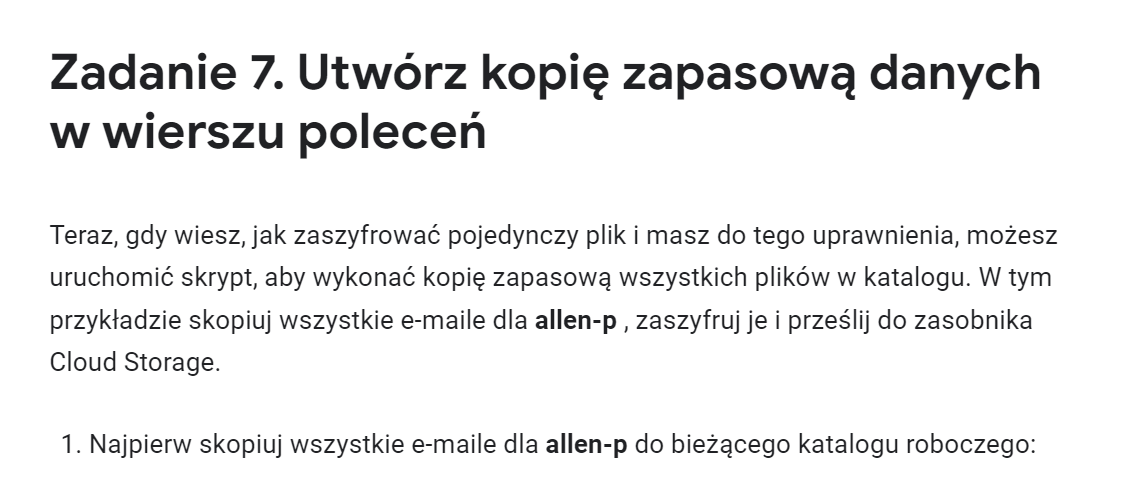

In [ ]:
gsutil -m cp -r gs://enron_emails/allen-p .

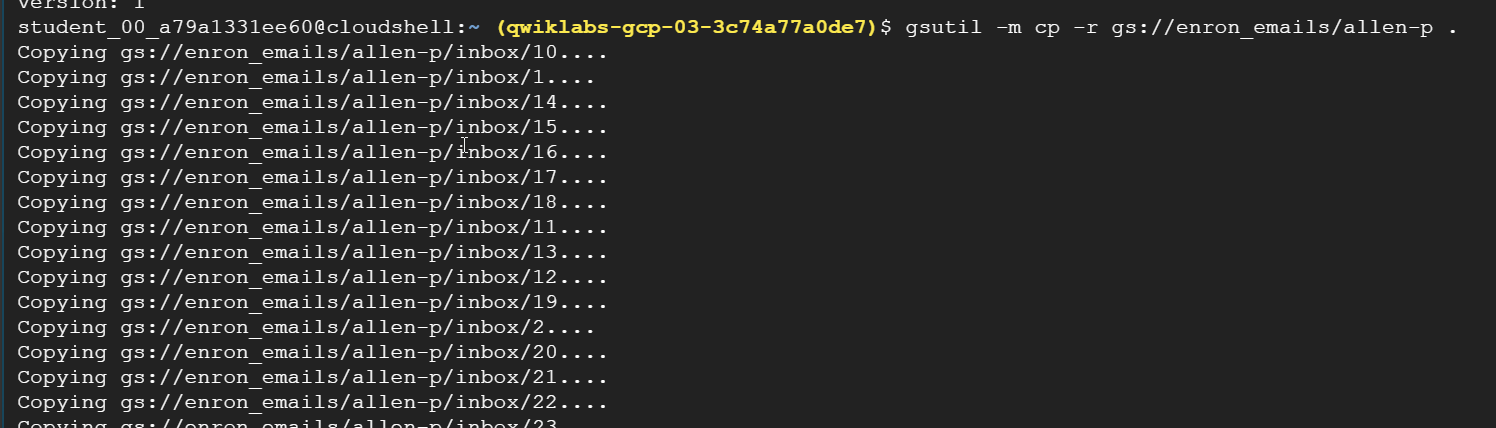

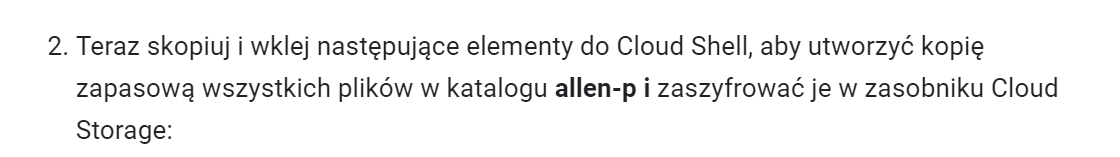

In [ ]:
MYDIR=allen-p
FILES=$(find $MYDIR -type f -not -name "*.encrypted")
for file in $FILES; do
  PLAINTEXT=$(cat $file | base64 -w0)
  curl -v "https://cloudkms.googleapis.com/v1/projects/$DEVSHELL_PROJECT_ID/locations/global/keyRings/$KEYRING_NAME/cryptoKeys/$CRYPTOKEY_NAME:encrypt" \
    -d "{\"plaintext\":\"$PLAINTEXT\"}" \
    -H "Authorization:Bearer $(gcloud auth application-default print-access-token)" \
    -H "Content-Type:application/json" \
  | jq .ciphertext -r > $file.encrypted
done
gsutil -m cp allen-p/inbox/*.encrypted gs://${BUCKET_NAME}/allen-p/inbox

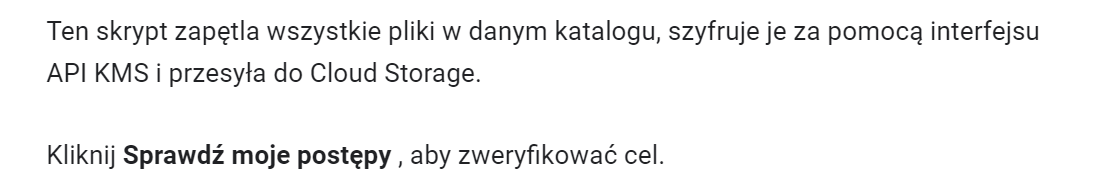

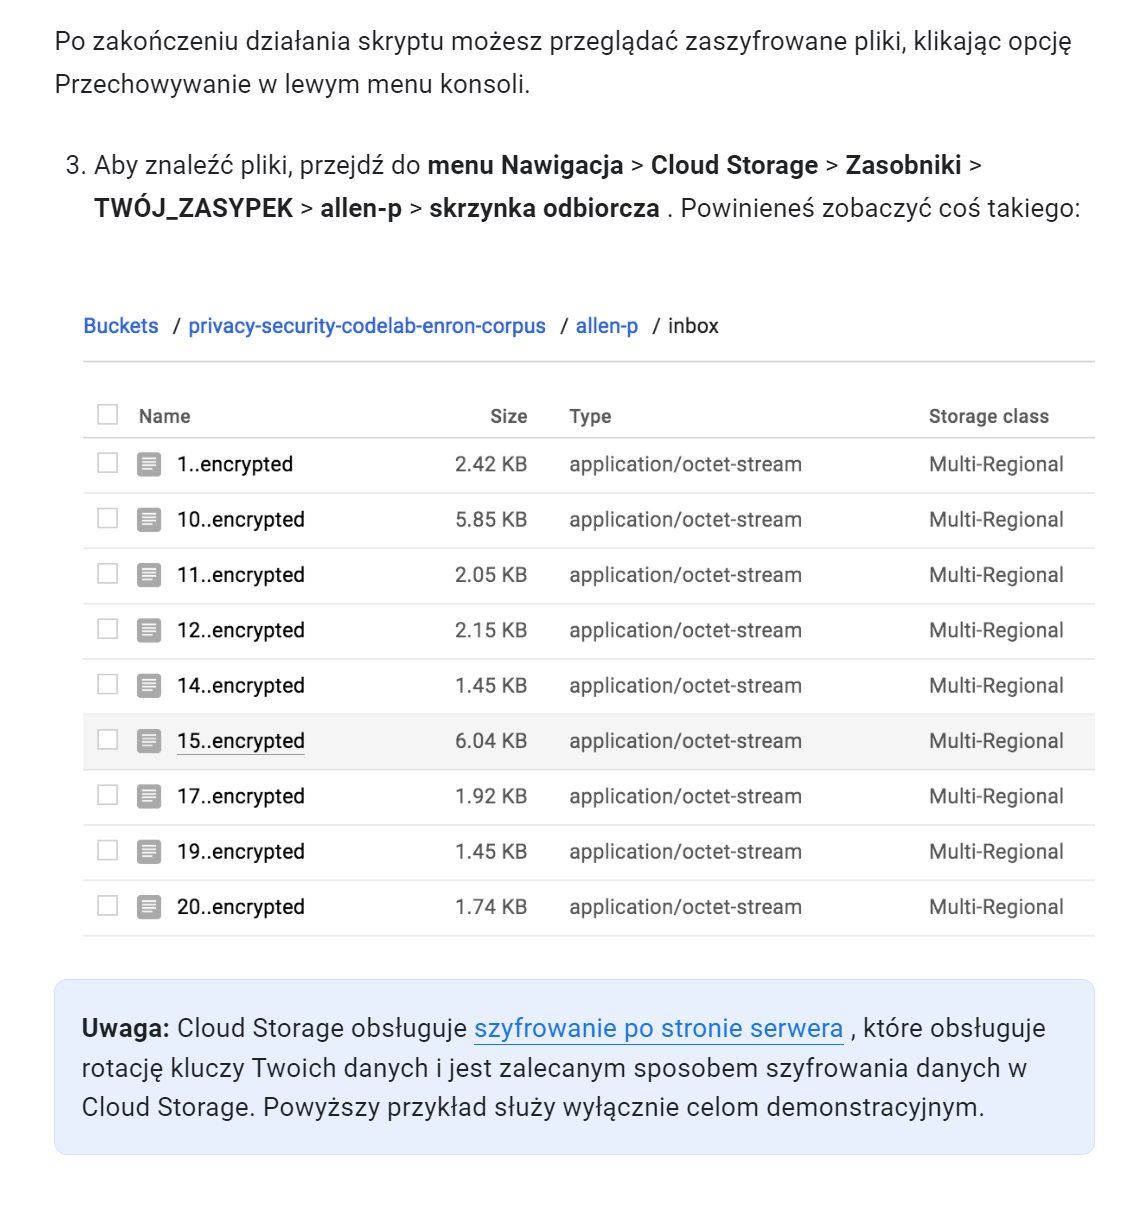

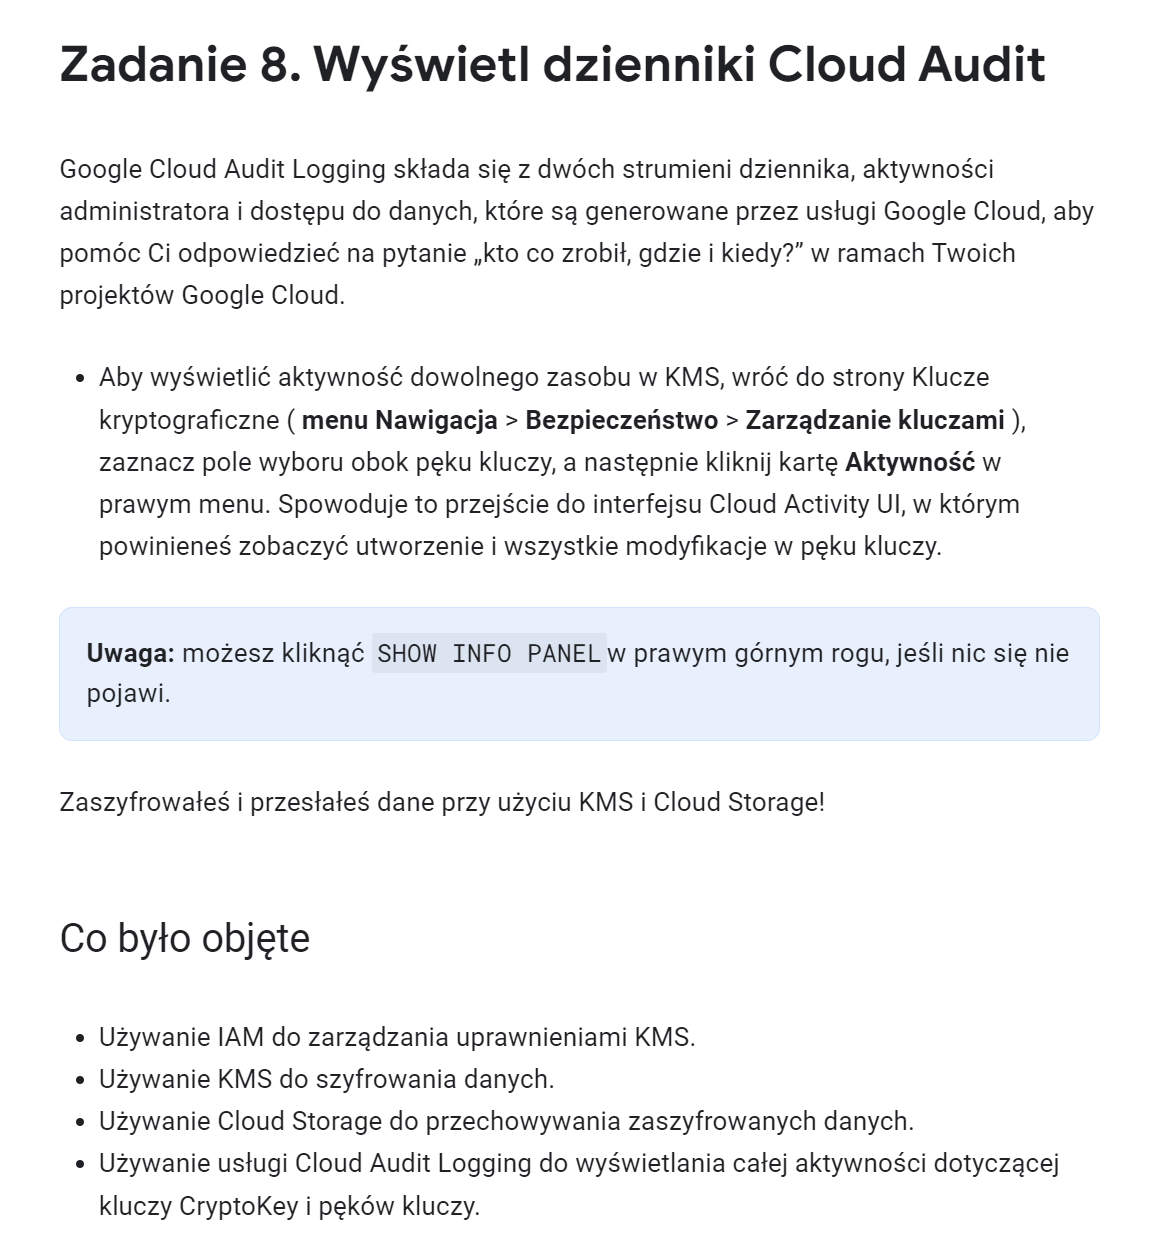

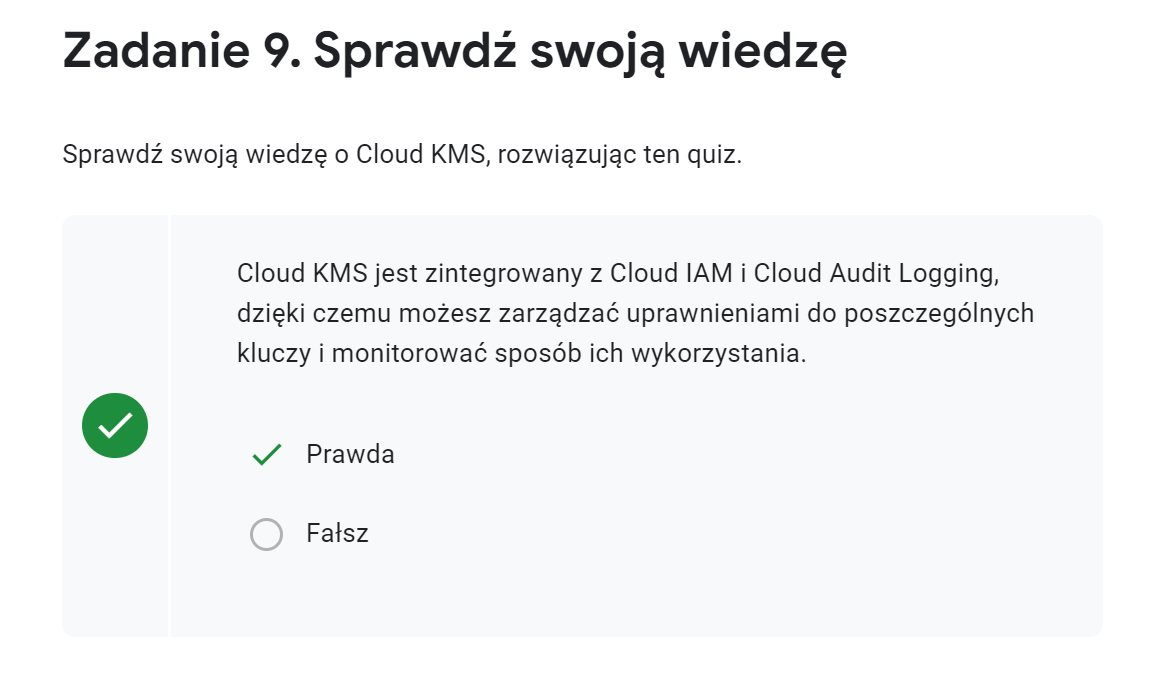